On imagine ici un terrain 

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json

import random

from ortools.sat.python import cp_model
import sys
import os
import matplotlib
import matplotlib.pyplot as plt

import itertools

import uuid
import math
import json
import copy

from enum import Enum, unique
from random import randint

## Utils functions

In [12]:
def getFarValues(data, val, rg):
    """Retrieve the farthest values from a value and a max distance
    Args:
        data (list): list containing objects
        val (int): reference point
        rg (int): distance between reference point and all list's values
    Returns:
        list containing elements with ditance > rg
    """
    l = []
    for e in data:
        if abs(e.sunExposureTime - val) > rg:
            l.append(e)
    return l

In [13]:
class Box():
    
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color):
        self.__name = name
        self.__pos_x = int(pos_x * 10)
        self.__pos_y = int(pos_y * 10)
        self.__dim_x = int(dim_x * 10)
        self.__dim_y = int(dim_y * 10)
        self.__color = str(color)
    
    @property
    def name(self):
        return self.__name
    
    @property
    def pos_x(self):
        return self.__pos_x
    
    @property
    def color(self):
        return self.__color
    
    @property
    def pos_y(self):
        return self.__pos_y
    
    @property
    def dim_x(self):
        return self.__dim_x
    
    @property
    def dim_y(self):
        return self.__dim_y
    
    @name.setter
    def name(self, value):
        self.__name = value
    
    @pos_x.setter
    def pos_x(self, value):
        self.__pos_x = value
    
    @pos_y.setter
    def pos_y(self, value):
        self.__pos_y = value
        
    @dim_x.setter
    def dim_x(self, value):
        self.__dim_x = value
        
    @dim_y.setter
    def dim_y(self, value):
        self.__dim_y = value
        
    @color.setter
    def color(self, color):
        self.__color = color
        
    def __str__(self):
        return 'name: {} \n pos_x: {} \n pos_y: {}'.format(self.name, self.pos_x, self.pos_y)
        
class BoxFixed(Box): 
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)

class BoxMovable(Box):
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)

In [14]:
class Plant(BoxMovable):
    """Set plant square in modelisation"""
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color, sunExposureTime, soilTypeAvoided):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)
        self.__sunExposureTime = sunExposureTime
        self.__soilTypeAvoided = soilTypeAvoided
    @property
    def sunExposureTime(self):
        return self.__sunExposureTime
    
    @property
    def soilTypeAvoided(self):
        return self.__soilTypeAvoided
          
    @sunExposureTime.setter
    def sunExposureTime(self, sunExposureTime):
        self.__sunExposureTime = sunExposureTime
        
    @soilTypeAvoided.setter
    def soilTypeAvoided(self, soilTypeAvoided):
        self.__soilTypeAvoided = soilTypeAvoided
        
class Sun(BoxFixed):
    """Set luminosity square in modelisation"""
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color, sunExposureTime):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)
        self.__sunExposureTime = sunExposureTime
    
    @property
    def sunExposureTime(self):
        return self.__sunExposureTime
    
    @sunExposureTime.setter
    def sunExposureTime(self, sunExposureTime):
        self.__sunExposureTime = sunExposureTime
        
class Soil(BoxFixed):
    """Set soil square in modelisation"""
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color, soilType):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)
        self.__soilType = soilType
    
    @property
    def soilType(self):
        return self.__soilType
    
    @soilType.setter
    def soilType(self, soilType):
        self.__soilType = soilType


In [15]:
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variable_list, limit, gardenUser):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variable_list = variable_list
        self.__solution_count = 0
        self.__solution_limit = limit
        self.garden = gardenUser
        self.cpt = 1

    def on_solution_callback(self):
        self.__solution_count += 1
        fig = plt.figure()
        ax = fig.add_subplot(111)
        legend_list = []
        
        data = {}
        jsonToSave = {}
        
        for shape in self.__variable_list:
            # Test obligatoire car si valeur fixe le modèle plante
            pos_x = self.Value(shape[0]) / 10.0 
            pos_y = self.Value(shape[1]) / 10.0 
            dim_x = self.Value(shape[2]) / 10.0 
            dim_y = self.Value(shape[3]) / 10.0
            color = shape[4]
            name = shape[5]
                     
            if self.__solution_count % 10 == 0:
                dictVege = {
                  "posX": pos_x,
                  "posY": pos_y,
                  "dimX": dim_x,
                  "dimY": dim_y
                }
                
                data[name] = dictVege

            if name != 'Humifere' and name != "ArgileuxLimoneux" and name != "Calcaire":
                print('name = %s' % name)
                print('pos_x = %f' % pos_x)
                print('pos_y = %f' % pos_y)
                print('dim_x = %f' % dim_x)
                print('dim_y = %f' % dim_y)
                alpha = 0.4
            else:
                alpha = 0.2
            
            rect = matplotlib.patches.Rectangle((pos_x, pos_y),
                                                dim_x, dim_y , color=color, alpha=alpha)   
            ax.add_patch(rect)

            # Display in graph
            if name != "light_sunlight" and name != "full_sunlight" and name != 'Humifere' and name != "ArgileuxLimoneux" and name != "Calcaire":
                ax.text(pos_x + (dim_x / 2) , pos_y + (dim_y / 2) , name, fontsize=8, horizontalalignment='center',verticalalignment='center')
            # Display in right legend
            else:
                if len(legend_list) == 0:
                    ax.scatter(pos_x, pos_y, c=color, s=None, label=name, alpha=alpha, edgecolors='none')
                    legend_list.append(name)
                else:
                    if name not in legend_list:
                        ax.scatter(pos_x, pos_y, c=color, s=None, label=name, alpha=alpha, edgecolors='none')
                        legend_list.append(name)
                        
        if self.__solution_count % 10 == 0:
            jsonToSave["vegetables"] = data
            print(jsonToSave)
            with open('userJSON/' + str(self.garden.nameUser) + '_' + str(self.cpt) + '.json', 'w') as outfile:
                json.dump(jsonToSave, outfile)
            self.cpt += 1    
        ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
        plt.xlim([0, self.garden.sizeW])
        plt.ylim([0, self.garden.sizeH])
        plt.gca().set_aspect('equal', adjustable='box')  
        #plt.show()
        
          
        if self.__solution_count >= self.__solution_limit:
            print('Stop search after %i solutions' % self.__solution_limit)
            self.StopSearch()
        
    def solution_count(self):
        return self.__solution_count

In [16]:
def displayJSON(file):
    print(json.dumps(file, indent=4))


class plantBoxProblem():
    def __init__(self, box):
        # model initialisation
        self.__model = cp_model.CpModel()
        
        # solver creation
        self.__solver = cp_model.CpSolver()
        
        # init main box
        self.__box = box

        # init list of plants
        self.__elem_list = []
        
        #self.__json_file = path_json
        
    @property
    def box(self):
        return self.__box
    
    @property
    def model(self):
        return self.__model
    
    @property
    def solver(self):
        return self.__solver
    
    @property
    def elem_list(self):
        return self.__elem_list
    
    @property
    def json_file(self):
        return self.__json_file
    
    @box.setter
    def box(self, value):
        self.__box = value

    @model.setter
    def model(self, value):
        self.__model = value
    
    @solver.setter
    def solver(self, value):
        self.__solver = value
        
    @elem_list.setter
    def elem_list(self, value):
        self.__elem_list = value
              

    def boxesDistance(self, b1, b2, min_dist = 0, max_dist = 0):
        
        b2_h_left_limit = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_h_right_limit = self.__model.NewBoolVar(str(uuid.uuid4()))
        h_perimeter_cond = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_up_min_cst = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_up_max_cst = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_down_min_cst = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_down_max_cst = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_up_csts = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_dw_csts = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_v_down_limit = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_v_up_limit = self.__model.NewBoolVar(str(uuid.uuid4()))
        v_perimeter_cond = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_left_min_cst = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_left_max_cst = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_right_min_cst = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_right_max_cst = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_left_csts = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_right_csts = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_up_dw_conclusion = self.__model.NewBoolVar(str(uuid.uuid4()))
        b2_left_right_conclusion = self.__model.NewBoolVar(str(uuid.uuid4()))

        # Horizontal constraints conditions
        # Horizontal perimeter where a box can be
        self.__model.Add(b2.pos_x >= b1.pos_x - int(max_dist * 10)).OnlyEnforceIf(b2_h_left_limit)
        self.__model.Add(b2.pos_x <= b1.pos_x + b1.dim_x + int(max_dist * 10)).OnlyEnforceIf(b2_h_right_limit)
        
        # channeling both conditions part
        self.__model.AddBoolAnd([b2_h_left_limit,b2_h_right_limit]).OnlyEnforceIf(h_perimeter_cond)
                
        #  conclusions
        # Up constraints
        self.__model.Add(b2.pos_y >= b1.pos_y + b1.dim_y + int(min_dist * 10)).OnlyEnforceIf(b2_up_min_cst)
        self.__model.Add(b2.pos_y <= b1.pos_y + b1.dim_y + int(max_dist * 10)).OnlyEnforceIf(b2_up_max_cst)

        # Down constraints
        self.__model.Add(b2.pos_y <= b1.pos_y - b2.dim_y - int(min_dist * 10)).OnlyEnforceIf(b2_down_min_cst)
        self.__model.Add(b2.pos_y >= b1.pos_y - b2.dim_y - int(max_dist * 10)).OnlyEnforceIf(b2_down_max_cst)
        # channeling up & down constraints
        self.__model.AddBoolAnd([b2_up_min_cst,b2_up_max_cst]).OnlyEnforceIf(b2_up_csts)
        self.__model.AddBoolAnd([b2_down_min_cst,b2_down_max_cst]).OnlyEnforceIf(b2_dw_csts)

        
        
        # Vertical perimeter where a box can be
        self.__model.Add(b2.pos_y >= b1.pos_x - int(max_dist * 10)).OnlyEnforceIf(b2_v_down_limit)
        self.__model.Add(b2.pos_y <= b1.pos_x + b1.dim_x + int(max_dist * 10)).OnlyEnforceIf(b2_v_up_limit)

        # channeling both conditions part
        self.__model.AddBoolAnd([b2_v_down_limit,b2_v_up_limit]).OnlyEnforceIf(v_perimeter_cond)
        
        #  conclusions
        # left constraints
        self.__model.Add(b2.pos_x <= b1.pos_x - b2.dim_x - int(min_dist * 10)).OnlyEnforceIf(b2_left_min_cst)
        self.__model.Add(b2.pos_x >= b1.pos_x - b2.dim_x - int(max_dist * 10)).OnlyEnforceIf(b2_left_max_cst)

        # right constraints
        self.__model.Add(b2.pos_x >= b1.pos_x + b1.dim_x + int(min_dist * 10)).OnlyEnforceIf(b2_right_min_cst)
        self.__model.Add(b2.pos_x <= b1.pos_x + b1.dim_x + int(max_dist * 10)).OnlyEnforceIf(b2_right_max_cst)

        # channeling left & right constraints
        self.__model.AddBoolAnd([b2_left_min_cst,b2_left_max_cst]).OnlyEnforceIf(b2_left_csts)
        self.__model.AddBoolAnd([b2_right_min_cst,b2_right_max_cst]).OnlyEnforceIf(b2_right_csts)

        # up & down conclusions => b2_up_dw_conclusion
        self.__model.AddBoolOr([b2_up_csts, b2_dw_csts]).OnlyEnforceIf(b2_up_dw_conclusion)
                
        # left & right conclusions => u
        self.__model.AddBoolOr([b2_left_csts, b2_right_csts]).OnlyEnforceIf(b2_left_right_conclusion) 
        
        #  == True =>
        self.__model.AddBoolAnd([b2_up_dw_conclusion, 1]).OnlyEnforceIf(h_perimeter_cond)
        
        #  == True =>
        self.__model.AddBoolAnd([b2_left_right_conclusion, 1]).OnlyEnforceIf(v_perimeter_cond)

        self.__model.AddBoolOr([h_perimeter_cond, v_perimeter_cond])
        
        
        # Redondance

        # Horizontal constraints conditions
        # Horizontal perimeter where a box can't be
        self.__model.Add(b2.pos_x < b1.pos_x - int(max_dist * 10)).OnlyEnforceIf(b2_h_left_limit.Not())
        self.__model.Add(b2.pos_x > b1.pos_x + b1.dim_x + int(max_dist * 10)).OnlyEnforceIf(b2_h_right_limit.Not())
        
        # channeling both conditions part
        #self.__model.AddBoolOr([b2_h_left_limit.Not(),b2_h_right_limit.Not()]).OnlyEnforceIf(h_perimeter_cond.Not())
                
        #  conclusions
        # Up constraints
        self.__model.Add(b2.pos_y < b1.pos_y + b1.dim_y + int(min_dist * 10)).OnlyEnforceIf(b2_up_min_cst.Not())
        self.__model.Add(b2.pos_y > b1.pos_y + b1.dim_y + int(max_dist * 10)).OnlyEnforceIf(b2_up_max_cst.Not())

        # Down constraints
        self.__model.Add(b2.pos_y > b1.pos_y - b2.dim_y - int(min_dist * 10)).OnlyEnforceIf(b2_down_min_cst.Not())
        self.__model.Add(b2.pos_y < b1.pos_y - b2.dim_y - int(max_dist * 10)).OnlyEnforceIf(b2_down_max_cst.Not())

        # channeling up & down constraints
        self.__model.AddBoolOr([b2_up_min_cst.Not(),b2_up_max_cst.Not()]).OnlyEnforceIf(b2_up_csts.Not())
        self.__model.AddBoolOr([b2_down_min_cst.Not(),b2_down_max_cst.Not()]).OnlyEnforceIf(b2_dw_csts.Not())

        
        # Vertical constraints conditions
        self.__model.Add(b2.pos_y < b1.pos_x - int(max_dist * 10)).OnlyEnforceIf(b2_v_down_limit.Not())
        self.__model.Add(b2.pos_y > b1.pos_x + b1.dim_x + int(max_dist * 10)).OnlyEnforceIf(b2_v_up_limit.Not())

        # channeling both conditions part
        #self.__model.AddBoolOr([b2_v_down_limit.Not(),b2_v_up_limit.Not()]).OnlyEnforceIf(v_perimeter_cond.Not())
        
        #  conclusions
        # left constraints
        self.__model.Add(b2.pos_x > b1.pos_x - b2.dim_x - int(min_dist * 10)).OnlyEnforceIf(b2_left_min_cst.Not())
        self.__model.Add(b2.pos_x < b1.pos_x - b2.dim_x - int(max_dist * 10)).OnlyEnforceIf(b2_left_max_cst.Not())

        # right constraints
        self.__model.Add(b2.pos_x < b1.pos_x + b1.dim_x + int(min_dist * 10)).OnlyEnforceIf(b2_right_min_cst.Not())
        self.__model.Add(b2.pos_x > b1.pos_x + b1.dim_x + int(max_dist * 10)).OnlyEnforceIf(b2_right_max_cst.Not())

        # channeling left & right constraints
        self.__model.AddBoolOr([b2_left_min_cst.Not(),b2_left_max_cst.Not()]).OnlyEnforceIf(b2_left_csts.Not())
        self.__model.AddBoolOr([b2_right_min_cst.Not(),b2_right_max_cst.Not()]).OnlyEnforceIf(b2_right_csts.Not())

        
        ## up & down conclusions => b2_up_dw_conclusion
        self.__model.AddBoolAnd([b2_up_csts.Not(), b2_dw_csts.Not()]).OnlyEnforceIf(b2_up_dw_conclusion.Not())
                
        # left & right conclusions => b2_left_right_conclusion
        self.__model.AddBoolAnd([b2_left_csts.Not(), b2_right_csts.Not()]).OnlyEnforceIf(b2_left_right_conclusion.Not()) 
        
        # c == True =>
        self.__model.AddBoolOr([b2_up_dw_conclusion.Not(), 0]).OnlyEnforceIf(h_perimeter_cond.Not())
        
        # l == True =>
        self.__model.AddBoolOr([b2_left_right_conclusion.Not(), 0]).OnlyEnforceIf(v_perimeter_cond.Not())

        
    def addVegetables(self, vegetableList):
        for elem in vegetableList:
            self.addBox(elem)

    

    def addSoil(self, soil):
        self.addBox(soil)
        return soil
  

    def plantsAssociations(self, b1, b2, dataPlants, dataAux):
        if not(isinstance(b1, Soil)):
            if dataAux.get(b1.name) != None:
                # b1 fait partie d'une plante auxiliaire
                if dataAux[b1.name]["plantsCombinations"].get(b2.name) != None:
                    print('{} -> {}'.format(b1.name, b2.name))
                    self.boxesDistance(b1, b2, dataAux[b1.name]["plantsCombinations"][b2.name]["dist_min"],dataAux[b1.name]["plantsCombinations"][b2.name]["dist_max"])
                    return
                else:
                    self.boxesDistance(b1, b2, 0.2, 4)
                    return 

            if dataPlants.get(b1.name) != None:
                # b1 fait partie d'une plante potagère
                if dataPlants[b1.name]["plantsCombinations"].get(b2.name) != None:
                    # b1 plant -> b2 plant
                    self.boxesDistance(b1, b2, dataPlants[b1.name]["plantsCombinations"][b2.name]["dist_min"],dataPlants[b1.name]["plantsCombinations"][b2.name]["dist_max"])
                    print('{} -> {}'.format(b1.name, b2.name))
                    return
                else:
                    self.boxesDistance(b1, b2, 0.2, 4)
                if dataAux.get(b2.name) != None:
                    if dataAux[b2.name]["plantsCombinations"].get(b1.name) != None:
                        print('{} -> {}'.format(b1.name, b2.name))
                        self.boxesDistance(b1, b2, dataAux[b2.name]["plantsCombinations"][b1.name]["dist_min"],dataAux[b2.name]["plantsCombinations"][b1.name]["dist_max"])
                        return
                    else:
                        self.boxesDistance(b1, b2, 0.2, 4)
                else:
                    self.boxesDistance(b1, b2, 0.2, 4)
            else:
                # Traitement par defaut pour eviter qu'une plante overlap sur une autre
                #print("Else rencontré")
                print('{} -> {}'.format(b1.name, b2.name))
                self.boxesDistance(b1, b2, 0.2, 4)
        else:
            None

    # Il faut d'autres dimensions ici -> la premiere surtout 
    # En fonction de la plante avec la quelle je vais m'associer
    # je vais checker sa dim la plus grande, si sa dim_x est plus grande
    # alors je prend sa dim_x pour la mettre ici avec un dim_x fine (0.2), sinon inverse
    # cela permet de greffer la plante auxiliaire au meilleur endroit
    
    def calculateDimAuxiliaire(self, legume):
        if legume.dim_x >= legume.dim_y:
            return (legume.dim_x)/10, 0.2
        else:
            return 0.2, (legume.dim_y)/10
        

        
    
    
    def getAuxiliaryPlants(self, legume, dataAux):    
        auxList = []
        for auxName in dataAux:   
            if dataAux[auxName]["plantsCombinations"].get(legume.name) != None:
                print("    aux:",auxName)
                dimX, dimY = self.calculateDimAuxiliaire(legume)
                auxPlant = Plant(auxName, 0, 0, dimX, dimY, "darkolivegreen", 13, ["Humifere"])
                auxList.append(auxPlant)
        return auxList   
    
    
    
    
    def setAssociationsConstraints(self, vegetableList, gardenUser):
        while(vegetableList):
            for x in vegetableList:
                if x != vegetableList[0]:
                    if isinstance(x, Soil):
                        self.plantsSoil(x, gardenUser)
                    else:
                        self.plantsAssociations(vegetableList[0], x, gardenUser.dataPlants, gardenUser.dataAux)
            vegetableList.pop(0)
    
    def checkVegetablesFeasability(self, vegetableList, gardenUser):
        self.setAssociationsConstraints(list(vegetableList), gardenUser)
        status = self.solver.Solve(self.model)
        if status == cp_model.FEASIBLE:
            return True
        else:
            return False
        
    
    def plantsLuminosity(self, plant, data):
        """ Set noOverlap constraints with squares having farthest sunExposure values.
        Args:
            plant (Plant): reference plant. 
            data (Json file): json file containing sun infos. 
        Side effect:
            set noOverlap constraints in model.
        Returns:
            None
        """
        luminositySquares = getFarValues(data, plant.sunExposureTime, 4)
        for item in luminositySquares:
            self.noOverlap(plant, item)
    
    def plantsSoil(self, plant, gardenUser): 
        if gardenUser.soilType.name not in plant.soilType:
            self.noOverlap(plant, gardenUser.soilType)
        else:
            None
            
    def checkOrientation(self, plant):
        half_h = int(TAILLE_H / 2) * 10
        half_w = int(TAILLE_W / 2) * 10
        
        if plant.orientation != "None":
            for orien in plant.orientation:   
                if orien == "N":
                    self.__model.Add(((plant.pos_y + plant.dim_y) - plant.dim_y) > half_h)
                if orien == "S":
                    self.__model.Add(((plant.pos_y + plant.dim_y) - plant.dim_y) < half_h)
                if orien == "E": 
                    self.__model.Add(((plant.pos_x + plant.dim_x) - plant.dim_x) > half_w)
                if orien == "W": 
                    self.__model.Add(((plant.pos_x + plant.dim_x) - plant.dim_x) < half_w)
        
        
    def checkInside(self, b1, b2):
        """ Make sure one block goes into another
        Args:
            b1 (Box): first box to fit in b2. 
            b2 (Box): second box containing b1. 
        Side effect:
            set fit constraint b1 in b2
        Returns:
            None
        """
        self.__model.Add(b1.pos_x >= b2.pos_x)
        self.__model.Add(b1.pos_y >= b2.pos_y)
        self.__model.Add(b1.pos_x + b1.dim_x <= b2.pos_x + b2.dim_x)
        self.__model.Add(b1.pos_y + b1.dim_y <= b2.pos_y + b2.dim_y)
    
    def noOverlap(self, b1, b2):
        """ Set constraints 2 boxes don't overlap each other
        Args: 
            b1 (Box): first box
            b2 (Box): second box
        Side effect:
           set noOverlap constraints in model.
        Returns:
            None
        """
        a = self.__model.NewBoolVar(str(uuid.uuid4()))
        b = self.__model.NewBoolVar(str(uuid.uuid4()))
        c = self.__model.NewBoolVar(str(uuid.uuid4()))
        d = self.__model.NewBoolVar(str(uuid.uuid4()))
        
        self.__model.Add(b1.pos_x + b1.dim_x <= b2.pos_x).OnlyEnforceIf(a)
        self.__model.Add(b2.pos_x + b2.dim_x <= b1.pos_x).OnlyEnforceIf(b)
        self.__model.Add(b1.pos_y + b1.dim_y <= b2.pos_y).OnlyEnforceIf(c)
        self.__model.Add(b2.pos_y + b2.dim_y <= b1.pos_y).OnlyEnforceIf(d)
        
        # (redundant) constraints to help the solver to cut some branches
        self.__model.Add(b1.pos_x + b1.dim_x > b2.pos_x).OnlyEnforceIf(a.Not())
        self.__model.Add(b2.pos_x + b2.dim_x > b1.pos_x).OnlyEnforceIf(b.Not())
        self.__model.Add(b1.pos_y + b1.dim_y > b2.pos_y).OnlyEnforceIf(c.Not())
        self.__model.Add(b2.pos_y + b2.dim_y > b1.pos_y).OnlyEnforceIf(d.Not())
        
        self.__model.AddBoolOr([a,b,c,d])
        
    def addBox(self, box):
        """ Adding a box in model
        
        Args: 
            box (Box): box to add in model
        Side effect:
            Set domain variables for pos_x, pos_y, dim_x, dim_y 
        Returns:
            None
        """
        # If we can move the box 
        if isinstance(box, BoxMovable):
            box.pos_x = self.__model.NewIntVar(0, self.__box.dim_x, 'b%i_pos_x' % len(self.__elem_list))    
            box.pos_y = self.__model.NewIntVar(0, self.__box.dim_y, 'b%i_pos_y' % len(self.__elem_list))

            # if we have a square
            if box.dim_x == box.dim_y:
                box.dim_x = self.__model.NewIntVar(box.dim_x, box.dim_x, 'b%i_dim_x' % len(self.__elem_list))  
                box.dim_y = self.__model.NewIntVar(box.dim_y, box.dim_y, 'b%i_dim_y' % len(self.__elem_list))
            else:
                b = box
                if box.dim_x < box.dim_y:
                    x = self.__model.NewEnumeratedIntVar([b.dim_x, b.dim_x, b.dim_y, b.dim_y], 'b%i_dim_x' % len(self.__elem_list))
                    y = self.__model.NewEnumeratedIntVar([b.dim_x, b.dim_x, b.dim_y, b.dim_y], 'b%i_dim_y' % len(self.__elem_list))
                    b.dim_x = x
                    b.dim_y = y
                else:
                    x = self.__model.NewEnumeratedIntVar([b.dim_y, b.dim_y, b.dim_x, b.dim_x ], 'b%i_dim_x' % len(self.__elem_list))
                    y = self.__model.NewEnumeratedIntVar([b.dim_y, b.dim_y, b.dim_x, b.dim_x], 'b%i_dim_y' % len(self.__elem_list))
                    b.dim_x = x
                    b.dim_y = y
                # This constraint allows rotation to 90°
                self.__model.Add(b.dim_x != b.dim_y) 
        else: 
            box.pos_x = self.__model.NewIntVar(box.pos_x, box.pos_x, 'b%i_pos_x' % len(self.__elem_list))    
            box.pos_y = self.__model.NewIntVar(box.pos_y, box.pos_y, 'b%i_pos_y' % len(self.__elem_list))
            box.dim_x = self.__model.NewIntVar(box.dim_x, box.dim_x, 'b%i_dim_x' % len(self.__elem_list))  
            box.dim_y = self.__model.NewIntVar(box.dim_y, box.dim_y, 'b%i_dim_y' % len(self.__elem_list))
 
        self.checkInside(box, self.__box)
        self.__elem_list.append(box)
        #print(box)
   

    def solve(self, gardenUser, iteration):
        l = []
        for elem in self.__elem_list:
            print(elem)
            sub_list = []
            sub_list.append(elem.pos_x)
            sub_list.append(elem.pos_y)
            sub_list.append(elem.dim_x)
            sub_list.append(elem.dim_y)
            sub_list.append(elem.color)
            sub_list.append(elem.name)
            #sub_list.append(elem.orientation)
            l.append(sub_list)
      
        solution_printer = VarArraySolutionPrinter(l, iteration, gardenUser)
        status = self.__solver.SearchForAllSolutions(self.__model, solution_printer)

        print('Status = %s' % self.__solver.StatusName(status))
        print('Number of solutions found: %i' % solution_printer.solution_count())

In [17]:
class GardenUser():
    def __init__(self, modelAPI):
        self.listOfPlants = []
        self.path = []

        with open("./data_model/plant-associations.json", 'r') as f:
            self.dataPlants = json.load(f)

        with open("./data_model/plant-services.json", 'r') as f:
            self.dataAux = json.load(f)

        with open(modelAPI, 'r') as f:
            self.jsonFromAPI = json.load(f)

#         import pdb
#         pdb.set_trace()
        self.nameUser = self.jsonFromAPI["name"]
    
        self.sizeW = self.jsonFromAPI["map"]["sizeW"]
        
        self.sizeH = self.jsonFromAPI["map"]["sizeH"]
        
        self.soilType = Soil(self.jsonFromAPI["map"]["soilType"],0, 0, self.sizeW, self.sizeH, "brown", self.jsonFromAPI["map"]["soilType"])

## User Interface
Pemamind's minimalist interface functions

In [18]:
def modifyUserString(string):
    string_format = ""
    for c in range(len(string)):
        if c == 0:
            string_format += str(string[c]).upper()
        else:
            string_format += str(string[c]).lower() 
    return string_format

def quantityComputation(gardenUser, name, nbPlant):
    dim_x = nbPlant * gardenUser.dataPlants[name]["distSamePlant"]
    if dim_x < gardenUser.sizeW:
        dim_y = gardenUser.dataPlants[name]["distLine"]
    else:
        delta = dim_x - gardenUser.sizeW
        # Ici c'etait juste un peu trop gros, donc on peut y caller sur sur deux lignes maintenant
        if delta < gardenUser.sizeW:
            dim_x = gardenUser.sizeW
            dim_y = gardenUser.dataPlants[name]["distLine"] * 2 
        else:
            # Ici c'est encore plus gros, donc on peut y caller sur sur trois lignes maintenant
            dim_x = gardenUser.sizeW
            dim_y = gardenUser.dataPlants[name]["distLine"] * 3
    return [dim_x, dim_y]


def displayListOfPlants(l):
    print([[x.name,l.count(x)] for x in set(l)])

    
def openInfoFromApiTEST(gardenUser):
    garden = {}
    gardenDim = {}

    for vegetable in gardenUser.jsonFromAPI["vegetables"]:
        print(vegetable)
        garden[vegetable] = gardenUser.jsonFromAPI["vegetables"][vegetable]['plants']
    
    for vegetable in garden:
        gardenDim[vegetable] = quantityComputation(gardenUser, vegetable, garden[vegetable])
    
    return gardenDim
        
    
def loadPlantsDebug(gardenUser, iteration):
    print("loadPlantDebug")
    gardenWithDim = openInfoFromApiTEST(gardenUser)
    for vegetables in gardenWithDim:
        gardenUser.listOfPlants.append(Plant(vegetables, 0, 0, 
                                  gardenWithDim[vegetables][0], gardenWithDim[vegetables][1],
                                  gardenUser.dataPlants[vegetables]["color"], 6, ["Humifere","Calcaire","Azote","Pauvre","Compact"]))
    
    garden = BoxFixed('Box', 0, 0, gardenUser.sizeW, gardenUser.sizeH, "white")
    blockProblem = createModel(garden, gardenUser)
    
    if blockProblem != -1:
        blockProblem.solve(gardenUser, iteration)
        print('Statistics')
        print('  - conflicts       : %i' % blockProblem.solver.NumConflicts())
        print('  - branches        : %i' % blockProblem.solver.NumBranches())
        print('  - wall time       : %f s' % blockProblem.solver.WallTime())
    else:
        print("PROBLEM")


def askUserModifyChoice(listOfPlants):
    print("\nAie Aie ...")
    print("Ton choix cher petit jardinier me semble difficile à satisfaire :( ")
    print("- Voici les plantes que tu désires ajouter")
 
    # TODO faire une function qui fais la liste bien présentée
    displayListOfPlants(listOfPlants)
    
    present = False
    while True:
        print("- Pourrions nous réduire la quantité d'une plante afin de satisfaire le modèle ?")
        answer = input()
        answer = modifyUserString(answer)
        if answer == "Oui":
            print("- Quelle plante ?")
            plant = True
            while type(plant) is not str:
                plant = input()
            plant = modifyUserString(plant)
            for e in listOfPlants:
                if e.name == plant:
                    while True:
                        print("Veux tu supprimer cette plante ou réduire sa quantité ?")
                        print("'Supprimer' ou 'Reduire' :)")
                        answ = input()
                        answ = modifyUserString(answ)
                        if answ == "Supprimer":
                            listOfPlants = [x for x in listOfPlants if plant not in x.name]
                            present = True
                            break
                        if answ == "Reduire":
                            listOfPlants = [x for x in listOfPlants if plant not in x.name]
                            print("Quelle est la nouvelle quantité pour {}".format(plant))
                            qt = input()
                            listOfPlants = insertPlantsWithQuantity(listOfPlants, plant, qt)
                            present = True
                            break
                    break
        elif answer == "Non":
            raise Exception("L'utilisateur ne veut pas changer son choix /!\ En construction /!\ ")
                    
        if present:
            print("Liste mise à jour ...")
            return listOfPlants
        else:
            print("Element non présent dans votre liste")
        
        
def welcome():
    print("             Bonjour petit paysan débutant ! \n                 Bienvenue sur Permamind !\n\n")
    print("- Pourrais tu me fournir les données du terrain que tu désires aménager s'il te plait ?")
    print("    ... /!\ En construction /!\ Récupération JSON simulant les données du terrain ...")    
    print("    Je vais te fournir les espèces de légumes bien adapté à ton terrain.")

    
def askUserAndAdjust(listOfPlants):
    welcome()
    while True:
        print("- Fais ta sélection parmis la liste proposée !")
        for e in dataPlants:
            print("   *", e)
        plant = True
        while type(plant) is not str:
            plant = input()
        plant = modifyUserString(plant)
        if plant in dataPlants:
            print("- Tu as choisi {}".format(plant))
            print("    Quelle quantité de {} desires tu ?".format(str(plant)))
            qt = input()
            print("- Tu as choisi de planter {} {}(s)".format(qt, str(plant)))
            
            listOfPlants = insertPlantsWithQuantity(listOfPlants, plant, qt)
            
            while True:
                listOfElem = copy.deepcopy(listOfPlants)                                                                                                         
                garden = BoxFixed('Box', 0, 0, TAILLE_W, TAILLE_H, "white")
                blockProblem = createModel(garden, listOfElem)

                status = blockProblem.solver.Solve(blockProblem.model)
                if status == cp_model.FEASIBLE:
                    print("- Desires tu continuer ?")
                    choice = input()
                    choice = modifyUserString(choice)
                    if choice == "Non":
                        return blockProblem, listOfPlants
                    else:
                        break
                else:
                    listOfPlants = askUserModifyChoice(listOfPlants)
        else:
            print("Ce que tu as choisi n'est pas dans la base.")
        
        # TDOO Fonction qui fais la liste des plantes intégrées ...
    

In [19]:
def emptyAuxList(listOfPlants):
    count = 0
    for plant in listOfPlants:
        if len(plant["aux_plants"]) == 0:
                count += 1

    if count == len(listOfPlants):
        return True
    else:
        return False

def addServicePlant(plantDict, plantIndex):
    if len(plantDict[plantIndex]["aux_plants"]) != 0:
        auxPlant = plantDict[plantIndex]["aux_plants"].pop(0)
        print("ajout auxiliaire: {}".format(auxPlant))
        return auxPlant
    else:
        return -1

def createModel(field, gardenUser):
    
    vegetableList = gardenUser.listOfPlants 
    listBis = copy.deepcopy(vegetableList)    
    blockProblem = plantBoxProblem(field)
    vegetableList.append(gardenUser.soilType)

    blockProblem.addVegetables(listBis)
    
    if blockProblem.checkVegetablesFeasability(listBis, gardenUser):
        listOfPlants = []
        
        # To calculate the max of iteration (max number of plantCombination)
        maxDim = 0
        for veg in gardenUser.dataAux:
            lenCombination = len(gardenUser.dataAux[veg]["plantsCombinations"])
            if lenCombination > maxDim:
                maxDim = lenCombination
        
        # Here we create a dictionnary for each plant and his auxPlants
        for veg in vegetableList:
            print("veg",veg.name)
            myDict = {'vegetable': veg, 'aux_plants': blockProblem.getAuxiliaryPlants(veg, gardenUser.dataAux)}      
            listOfPlants.append(myDict)
        
        index = 0
        listBis = copy.deepcopy(vegetableList)
        while index <= maxDim:
            if emptyAuxList(listOfPlants):
                blockProblem = plantBoxProblem(field)  
                blockProblem.setAssociationsConstraints(listBis, gardenUser)
                print(len(blockProblem.elem_list), blockProblem)
                return blockProblem            
            
            auxPlant = addServicePlant(listOfPlants, index)
            if auxPlant != -1:
                print("JAJOUTE OKLM UN AUXILIAIRE")
                listBis.append(auxPlant)
            listTemp = copy.deepcopy(listBis)
            
            blockProblem = plantBoxProblem(field)
            blockProblem.addVegetables(listTemp)
            blockProblem.setAssociationsConstraints(listTemp, gardenUser)
            print(len(blockProblem.elem_list))

            if blockProblem.checkVegetablesFeasability(listTemp, gardenUser):              
                print("ALLER ON AUGMENTE")
                index += 1
            else:
                print("JE TEN POP 1 SINON CEST SEC FRERO")
                listBis.pop(-1)
                blockProblem = plantBoxProblem(field)
                blockProblem.addVegetables(listBis)
                blockProblem.setAssociationsConstraints(listBis, gardenUser)
                print(len(blockProblem.elem_list))
                return blockProblem 
            
        return blockProblem           
    else:
        print("Il y a trop de plantes potagere pour ton terrain. Revois tes ambitions mon grand")
        print("N'hesite pas a modifier vegetableList")
        return -1
    

def problemResolution(pathToJson, iteration):
    gardenUser = GardenUser(pathToJson)
    loadPlantsDebug(gardenUser, iteration)    

# http://socialcompare.com/fr/comparison/association-de-legumes-au-jardin-potager-bio

loadPlantDebug
Poireau
Oignon
Carotte
Pois
Ail
Patate
Poireau -> Oignon
Poireau -> Carotte
Oignon -> Pois
Carotte -> Pois
Pois -> Ail
Pois -> Patate
veg Poireau
    aux: Celeri
veg Oignon
    aux: Basilic
veg Carotte
    aux: Aneth
veg Pois
    aux: Asperge
veg Ail
veg Patate
veg Humifere
ajout auxiliaire: name: Celeri 
 pos_x: 0 
 pos_y: 0
JAJOUTE OKLM UN AUXILIAIRE
Poireau -> Oignon
Poireau -> Carotte
Poireau -> Celeri
Oignon -> Pois
Carotte -> Pois
Pois -> Ail
Pois -> Patate
8
ALLER ON AUGMENTE
ajout auxiliaire: name: Basilic 
 pos_x: 0 
 pos_y: 0
JAJOUTE OKLM UN AUXILIAIRE
Poireau -> Oignon
Poireau -> Carotte
Poireau -> Celeri
Oignon -> Pois
Oignon -> Basilic
Carotte -> Pois
Pois -> Ail
Pois -> Patate
9
ALLER ON AUGMENTE
ajout auxiliaire: name: Aneth 
 pos_x: 0 
 pos_y: 0
JAJOUTE OKLM UN AUXILIAIRE
Poireau -> Oignon
Poireau -> Carotte
Poireau -> Celeri
Oignon -> Pois
Oignon -> Basilic
Carotte -> Pois
Carotte -> Aneth
Pois -> Ail
Pois -> Patate
10
ALLER ON AUGMENTE
name: Poireau 
 p

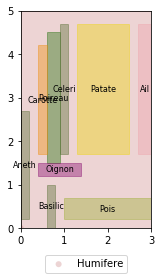

name = Poireau
pos_x = 0.600000
pos_y = 1.500000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.800000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.200000
dim_x = 0.200000
dim_y = 2.500000


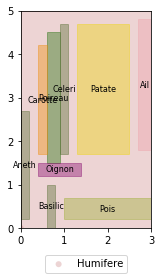

name = Poireau
pos_x = 0.600000
pos_y = 1.500000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.800000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.300000
dim_x = 0.200000
dim_y = 2.500000


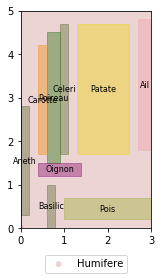

name = Poireau
pos_x = 0.600000
pos_y = 1.600000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.800000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.300000
dim_x = 0.200000
dim_y = 2.500000


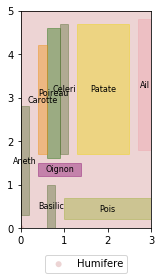

name = Poireau
pos_x = 0.600000
pos_y = 1.600000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.700000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.300000
dim_x = 0.200000
dim_y = 2.500000


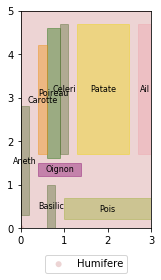

name = Poireau
pos_x = 0.600000
pos_y = 1.600000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.700000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.400000
dim_x = 0.200000
dim_y = 2.500000


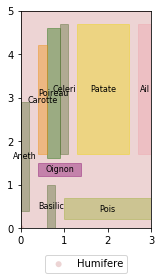

name = Poireau
pos_x = 0.600000
pos_y = 1.600000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.800000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.400000
dim_x = 0.200000
dim_y = 2.500000


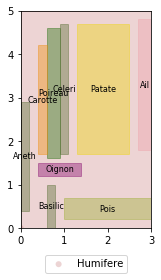

name = Poireau
pos_x = 0.600000
pos_y = 1.700000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.800000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.400000
dim_x = 0.200000
dim_y = 2.500000


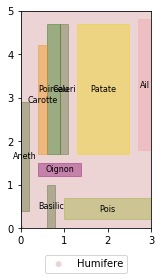

name = Poireau
pos_x = 0.600000
pos_y = 1.700000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.800000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.500000
dim_x = 0.200000
dim_y = 2.500000


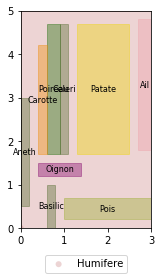

name = Poireau
pos_x = 0.600000
pos_y = 1.700000
dim_x = 0.300000
dim_y = 3.000000
name = Oignon
pos_x = 0.400000
pos_y = 1.200000
dim_x = 1.000000
dim_y = 0.300000
name = Carotte
pos_x = 0.400000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 2.500000
name = Pois
pos_x = 1.000000
pos_y = 0.200000
dim_x = 2.000000
dim_y = 0.500000
name = Ail
pos_x = 2.700000
pos_y = 1.800000
dim_x = 0.300000
dim_y = 3.000000
name = Patate
pos_x = 1.300000
pos_y = 1.700000
dim_x = 1.200000
dim_y = 3.000000
name = Celeri
pos_x = 0.900000
pos_y = 1.700000
dim_x = 0.200000
dim_y = 3.000000
name = Basilic
pos_x = 0.600000
pos_y = 0.000000
dim_x = 0.200000
dim_y = 1.000000
name = Aneth
pos_x = 0.000000
pos_y = 0.600000
dim_x = 0.200000
dim_y = 2.500000
{'vegetables': {'Poireau': {'posX': 0.6, 'posY': 1.7, 'dimX': 0.3, 'dimY': 3.0}, 'Oignon': {'posX': 0.4, 'posY': 1.2, 'dimX': 1.0, 'dimY': 0.3}, 'Carotte': {'posX': 0.4, 'posY': 1.7, 'dimX': 0.2, 'dimY': 2.5}, 'Pois': {'posX': 1.0, 'posY': 0.2, 'dimX': 2.0, 'dimY':

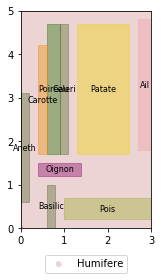

Stop search after 10 solutions
Status = FEASIBLE
Number of solutions found: 10
Statistics
  - conflicts       : 328
  - branches        : 8127
  - wall time       : 3.616980 s


In [20]:
iteration = 10
problemResolution("./API/sendToModeleToGenereModel.json", iteration)